
===== HARDWARE INFO =====
CPU: AMD64
GPU: Check nvidia-smi or system tools if available
Quantum Backend: Local classical simulator (FidelityQuantumKernel with Sampler)


===== TOP-3 FEATURES SELECTED =====
 • κ (Extinction coeff)
 • α (Absorption cm^-1)
 • Energy (eV)

[INFO] Using ONLY the top 3 features

===== VALIDATION MODULE =====
Ensuring dataset is genuine and classification is meaningful...

Dataset Loaded:
Train: 2304 | Val: 288 | Test: 289
CAF2 count: 1292 | ER count: 1589
Shuffled-label accuracy (expected ~0.5): 0.57
Dummy Classifier Test Accuracy: 0.55


===== Classical Support Vector Machine (SVM) =====
Train: 0.9765625
Val:   0.9791666666666666
Test:  0.9792387543252595

Test Classification Report:
              precision    recall  f1-score   support

        CaF2       0.98      0.97      0.98       130
     CaF2:Er       0.98      0.99      0.98       159

    accuracy                           0.98       289
   macro avg       0.98      0.98      0.98       289
weigh

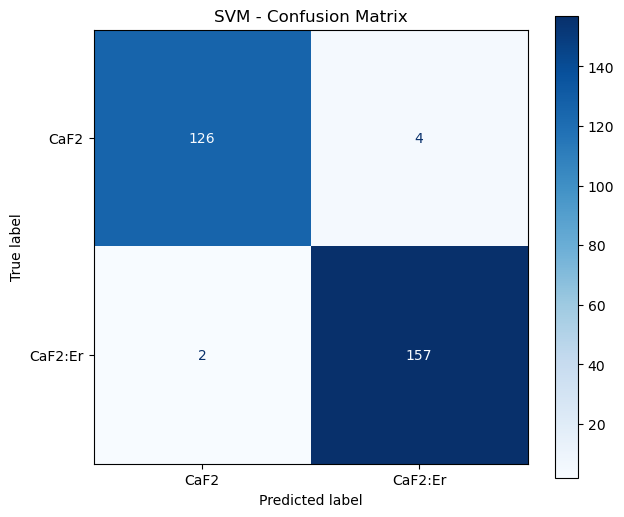

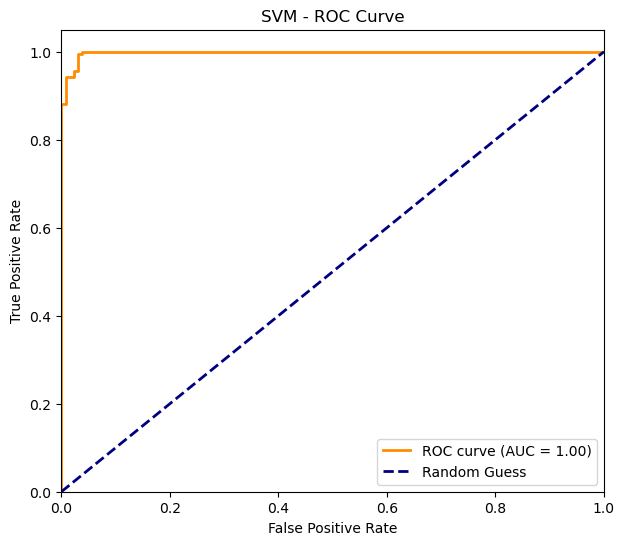


Feature Importance:
κ (Extinction coeff): 0.3858131487889274
α (Absorption cm^-1): 0.5013840830449828
Energy (eV): 0.28650519031141874


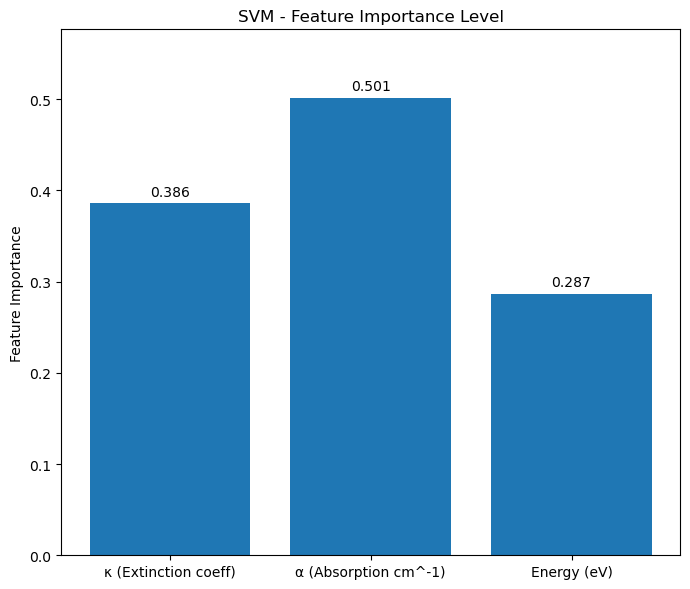


===== FIT ANALYSIS → Classical SVM =====
Train Acc: 0.977
Val Acc:   0.979
Gap:       -0.003
 GOOD FIT: No signs of over/underfitting.
===== Pegasos QSVM =====
PegasosQSVC Train Acc: 0.8780
PegasosQSVC Val Acc:   0.8854
PegasosQSVC Test Acc:  0.8478

PegasosQSVC Classification Report (Test):
              precision    recall  f1-score   support

           0       0.78      0.92      0.84       130
           1       0.92      0.79      0.85       159

    accuracy                           0.85       289
   macro avg       0.85      0.85      0.85       289
weighted avg       0.86      0.85      0.85       289



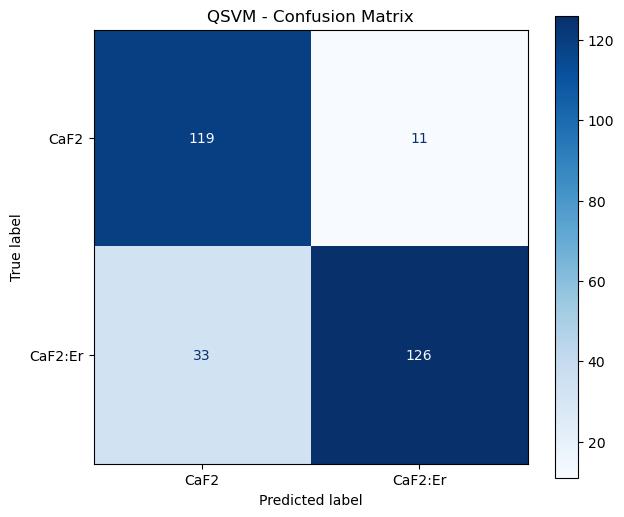

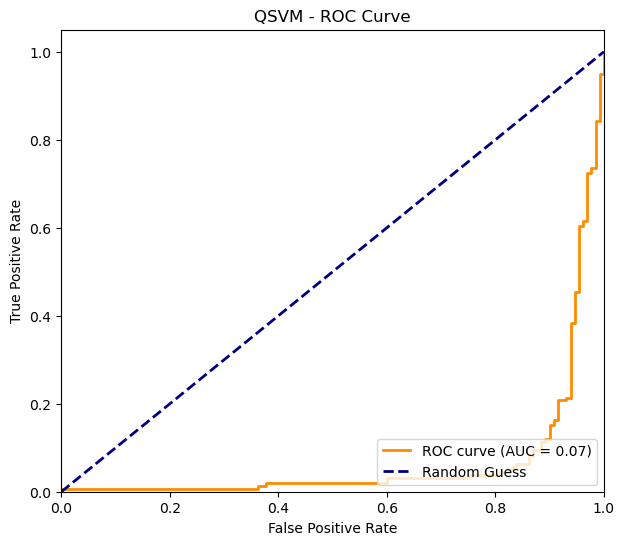


===== FIT ANALYSIS → QSVM =====
Train Acc: 0.878
Val Acc:   0.885
Gap:       -0.007
 GOOD FIT: No signs of over/underfitting.


In [1]:
# ============================================================
# IMPORTS
# ============================================================

import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC

from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import PegasosQSVC

# ============================================================
# GLOBAL CONFIG
# ============================================================

DATA_DIR = r"C:/Users/Kerem/Documents/University/EEE/Research/Q-UCSpec/data"
RANDOM_SEED = 0

MAX_QSVM_SAMPLES = 3000       # to keep kernel training light
TOP_K_FEATURES = 3            # use SVM-based feature selection if you like

FULL_FEATURES = [
    "Energy (eV)", "OscStrength", "Normalized f", "ε₁ (Real dielectric)",
    "ε₂ (Imag dielectric)", "n (Refractive index)", "κ (Extinction coeff)", "α (Absorption cm^-1)"
]

np.random.seed(RANDOM_SEED)

ACCURACY_RESULTS = {}

# ============================================================
# FIT ANALYSIS (Overfitting / Underfitting)
# ============================================================

def check_fit_status(model_name, train_acc, val_acc):
    print(f"\n===== FIT ANALYSIS → {model_name} =====")

    gap = train_acc - val_acc
    print(f"Train Acc: {train_acc:.3f}")
    print(f"Val Acc:   {val_acc:.3f}")
    print(f"Gap:       {gap:.3f}")

    if train_acc > 0.90 and gap > 0.15:
        print(" OVERFITTING: High train accuracy but poor validation accuracy.")
    elif gap > 0.10:
        print(" Mild Overfitting detected.")
    elif train_acc < 0.60 and val_acc < 0.60:
        print(" UNDERFITTING: Model cannot learn meaningful patterns.")
    else:
        print(" GOOD FIT: No signs of over/underfitting.")


# ============================================================
# UTILS: HARDWARE INFO
# ============================================================

def print_hardware_info():
    print("\n===== HARDWARE INFO =====")
    print(f"CPU: {platform.machine()}")
    # GPU info is environment-specific; print a generic line
    print("GPU: Check nvidia-smi or system tools if available")
    print("Quantum Backend: Local classical simulator (FidelityQuantumKernel with Sampler)")
    print("========================================\n")

# ============================================================
# DATA LOADING + SVM FEATURE SELECTION
# ============================================================

def load_dataset_top3():
    """
    Load the CaF2 / Er:CaF2 dataset, apply Box-Cox scaling and
    select TOP_K_FEATURES via linear SVM coefficients.
    Returns train/val/test splits with top-3 features.
    """
    caf2 = pd.read_csv(os.path.join(DATA_DIR, "caf2_qml_full_descriptors.csv"))
    er   = pd.read_csv(os.path.join(DATA_DIR, "caf2_er_qml_full_descriptors.csv"))

    caf2["label"] = 0
    er["label"]   = 1
    df = pd.concat([caf2, er], ignore_index=True)

    # Use all descriptor columns except 'label'
    X_full = df[FULL_FEATURES].values + 1e-6
    y      = df["label"].values

    X_train_full, X_temp_full, y_train, y_temp = train_test_split(
        X_full, y, test_size=0.20, stratify=y, random_state=RANDOM_SEED
    )
    X_val_full, X_test_full, y_val, y_test = train_test_split(
        X_temp_full, y_temp, test_size=0.50, stratify=y_temp, random_state=RANDOM_SEED
    )

    scaler = PowerTransformer(method="box-cox", standardize=True)
    X_train_s = scaler.fit_transform(X_train_full)
    X_val_s   = scaler.transform(X_val_full)
    X_test_s  = scaler.transform(X_test_full)

    # Linear SVM for feature ranking
    svm_linear = SVC(kernel="linear")
    svm_linear.fit(X_train_s, y_train)

    coefs = np.abs(svm_linear.coef_[0])
    top_idx = np.argsort(coefs)[-TOP_K_FEATURES:][::-1]
    top_features = [FULL_FEATURES[i] for i in top_idx]
    global FEATURES 
    FEATURES = top_features

    print("\n===== TOP-3 FEATURES SELECTED =====")
    for f in top_features:
        print(" •", f)
    print("====================================\n")
    print("[INFO] Using ONLY the top 3 features\n")

    X_train = X_train_s[:, top_idx]
    X_val   = X_val_s[:, top_idx]
    X_test  = X_test_s[:, top_idx]

    return X_train, X_val, X_test, y_train, y_val, y_test, top_features

# ============================================================
# VALIDATION MODULE
# ============================================================

def run_validation_tests(X_train, X_val, X_test, y_train, y_val, y_test):
    """
    Simple sanity checks: shuffled-label accuracy and dummy classifier.
    """
    print("===== VALIDATION MODULE =====")
    print("Ensuring dataset is genuine and classification is meaningful...\n")

    n_train = len(X_train)
    n_val   = len(X_val)
    n_test  = len(X_test)

    caf2_count = np.sum(np.concatenate([y_train, y_val, y_test]) == 0)
    er_count   = np.sum(np.concatenate([y_train, y_val, y_test]) == 1)

    print(f"Dataset Loaded:")
    print(f"Train: {n_train} | Val: {n_val} | Test: {n_test}")
    print(f"CAF2 count: {caf2_count} | ER count: {er_count}")

    # Shuffled-label test (expect ~0.5 accuracy)
    rng = np.random.default_rng(RANDOM_SEED)
    y_shuffled = rng.permutation(np.concatenate([y_train, y_val, y_test]))
    split1 = n_train
    split2 = n_train + n_val
    y_train_sh = y_shuffled[:split1]
    y_val_sh   = y_shuffled[split1:split2]
    y_test_sh  = y_shuffled[split2:]

    clf_shuffled = SVC(kernel="linear")
    clf_shuffled.fit(X_train, y_train_sh)
    y_test_pred_sh = clf_shuffled.predict(X_test)
    acc_shuffled = accuracy_score(y_test_sh, y_test_pred_sh)
    print(f"Shuffled-label accuracy (expected ~0.5): {acc_shuffled:.2f}")

    # Dummy classifier baseline
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_train, y_train)
    y_dummy_test = dummy.predict(X_test)
    acc_dummy = accuracy_score(y_test, y_dummy_test)
    print(f"Dummy Classifier Test Accuracy: {acc_dummy:.2f}")
    print()

# ============================================================
# Plots for post processing
# ============================================================

def plot_confusion_matrix(y_true, y_pred, title, labels=["CaF2", "CaF2:Er"]):
    fig, ax = plt.subplots(figsize=(7, 6))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', ax=ax)
    ax.set_title(title + ' - Confusion Matrix')
    plt.show()

def plot_roc_curve(y_true, y_proba, title):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title + ' - ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_feature_importance(model, X, y, title, n_repeats=5, seed=0):
    feature_importance = permutation_importance(model, X, y, scoring='accuracy', n_repeats=n_repeats, random_state=seed)
    feature_importance_score = feature_importance.importances_mean
    print("\nFeature Importance:")
    for i, importance in enumerate(feature_importance_score):
        print(f"{FEATURES[i]}: {importance}")

    plt.figure(figsize=(7, 6))
    bars = plt.bar(FEATURES, feature_importance_score)
    plt.ylim(0, max(feature_importance_score)*1.15)
    plt.title(title + ' - Feature Importance Level')
    plt.ylabel('Feature Importance')
    
    for bar, v in zip(bars, feature_importance_score):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.005,
            f"{v:.3f}",
            ha="center",
            va="bottom",
        )

    plt.tight_layout()
    plt.show()

def plot_accuracies(order, labels_pretty):
    print("\n===== Test Accuracy Comparison =====")

    labels = []
    values = []
    for key in order:
        if key in ACCURACY_RESULTS:
            labels.append(labels_pretty[key])
            values.append(ACCURACY_RESULTS[key]["test"])

    if not labels:
        print("No accuracy results to plot.")
        return

    plt.figure(figsize=(7, 6))
    bars = plt.bar(labels, values)
    plt.ylabel("Test Accuracy")
    plt.ylim(0, 1.05)
    plt.title("Test Accuracy: Classical vs Quantum")

    for bar, v in zip(bars, values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            f"{v:.3f}",
            ha="center",
            va="bottom",
        )

    plt.tight_layout()
    plt.show()

# ============================================================
# CLASSICAL BASELINE (SVC)
# ============================================================

def classical_baseline(X_train, y_train, X_val, y_val, X_test, y_test):
    print("\n===== Classical Support Vector Machine (SVM) =====")

    svm = SVC(kernel="rbf")
    svm.fit(X_train, y_train)

    # predictions
    pred_train = svm.predict(X_train)
    pred_val = svm.predict(X_val)
    pred_test = svm.predict(X_test)

    # classifier accuracy
    acc_train = accuracy_score(y_train, pred_train)
    acc_val = accuracy_score(y_val, pred_val)
    acc_test = accuracy_score(y_test,pred_test)

    ACCURACY_RESULTS["SVM"] = {
        "train": acc_train,
        "val": acc_val,
        "test": acc_test,
    }

    print("Train:", acc_train)
    print("Val:  ", acc_val)
    print("Test: ", acc_test)
    print("\nTest Classification Report:",)
    print(classification_report(y_test, pred_test, labels=[0,1], target_names=["CaF2", "CaF2:Er"]))

    # confusion matrix
    title = 'SVM'
    plot_confusion_matrix(y_test, pred_test, title, labels=["CaF2", "CaF2:Er"])

    # roc
    y_test_score = svm.decision_function(X_test)
    plot_roc_curve(y_test, y_test_score, title)

    # feature importance
    plot_feature_importance(svm, X_test, y_test, title, n_repeats=10, seed=0)

    check_fit_status("Classical SVM", acc_train, acc_val)

    return svm

# ============================================================
# PEGASOS QSVM
# ============================================================

def train_pegasos_qsvm(X_train, y_train, X_val, y_val, X_test, y_test):
    print("===== Pegasos QSVM =====")

    # Downsample training for kernel if needed
    if len(X_train) > MAX_QSVM_SAMPLES:
        rng = np.random.default_rng(RANDOM_SEED)
        idx = rng.choice(len(X_train), size=MAX_QSVM_SAMPLES, replace=False)
        X_train_q = X_train[idx]
        y_train_q = y_train[idx]
        print(f"[INFO] Downsampling QSVM training set to {MAX_QSVM_SAMPLES} samples.")
    else:
        X_train_q = X_train
        y_train_q = y_train

    feature_dimension = X_train.shape[1]

    # Feature map (same style as original QSVM)
    fmap = ZZFeatureMap(feature_dimension=feature_dimension, reps=1)

    qkernel = FidelityQuantumKernel(
        feature_map=fmap,
    )

    # Pegasos QSVC
    C = 1000.0
    num_steps = 1000

    qsvc = PegasosQSVC(
        quantum_kernel=qkernel,
        C=C,
        num_steps=num_steps,
        seed=RANDOM_SEED,
    )

    # Fit and evaluate
    qsvc.fit(X_train_q, y_train_q)

    acc_train = qsvc.score(X_train, y_train)
    acc_val   = qsvc.score(X_val,   y_val)
    acc_test  = qsvc.score(X_test,  y_test)

    # predictions
    pred_train = qsvc.predict(X_train)
    pred_val = qsvc.predict(X_val)
    pred_test = qsvc.predict(X_test)

    print(f"PegasosQSVC Train Acc: {acc_train:.4f}")
    print(f"PegasosQSVC Val Acc:   {acc_val:.4f}")
    print(f"PegasosQSVC Test Acc:  {acc_test:.4f}\n")

    print("PegasosQSVC Classification Report (Test):")
    print(classification_report(y_test, qsvc.predict(X_test)))

    # confusion matrix
    title = 'QSVM'
    plot_confusion_matrix(y_test, pred_test, title, labels=["CaF2", "CaF2:Er"])

    # roc
    
    y_test_proba = qsvc.predict_proba(X_test)[:, 1]  # probability of class 1
    plot_roc_curve(y_test, y_test_proba, title)


    check_fit_status("QSVM", acc_train, acc_val)

    return qsvc

# ============================================================
# MASTER PIPELINE
# ============================================================

def run_pipeline():
    np.random.seed(RANDOM_SEED)
    print_hardware_info()

    X_train, X_val, X_test, y_train, y_val, y_test, top3 = load_dataset_top3()

    # Validation checks
    run_validation_tests(X_train, X_val, X_test, y_train, y_val, y_test)

    # Models
    classical_baseline(X_train, y_train, X_val, y_val, X_test, y_test)
    train_pegasos_qsvm(X_train, y_train, X_val, y_val, X_test, y_test)

# ============================================================
# EXECUTE
# ============================================================

run_pipeline()
